In [2]:
# librerias
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Ejercicio 1: Correlacion

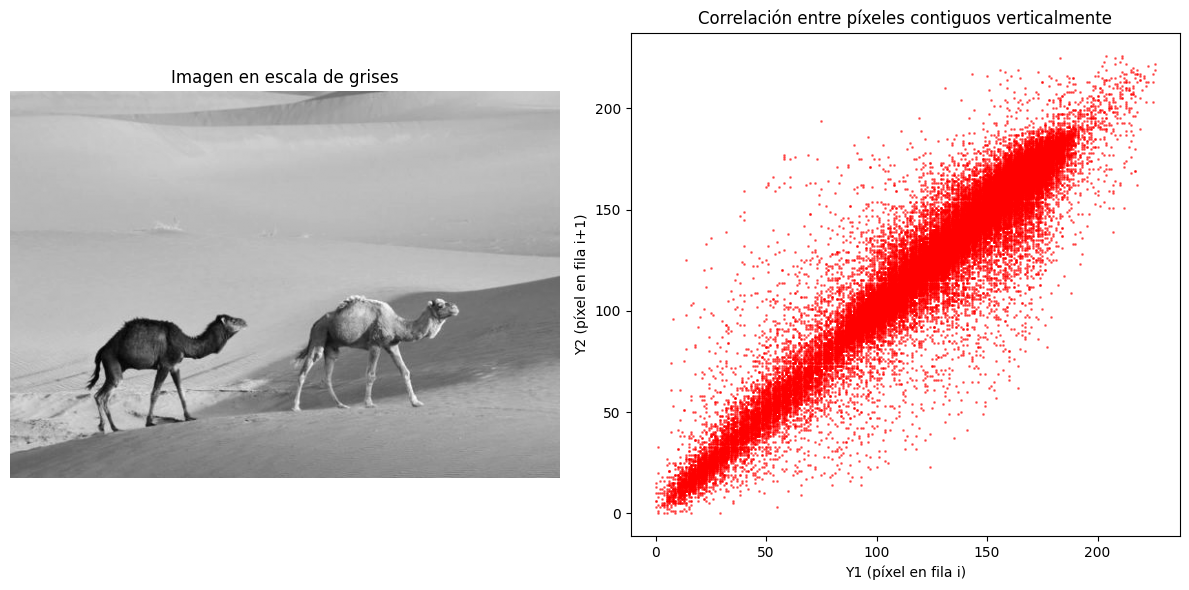

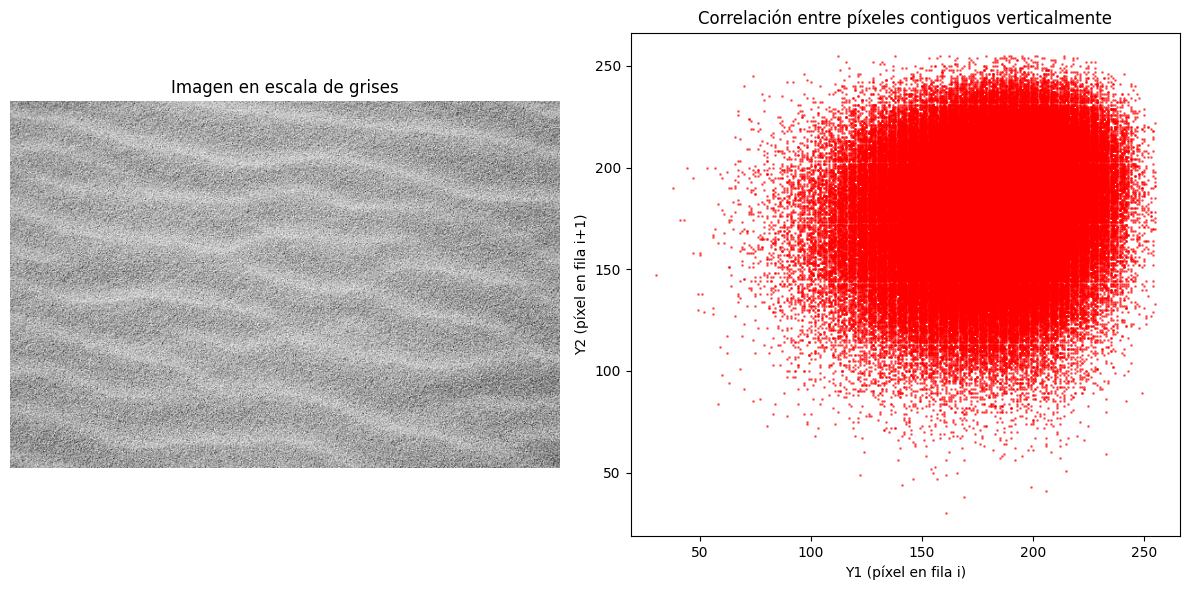

Coeficientes de correlación imagen 1: 0.9789354535355674
Coeficientes de correlación imagen 2: 0.14604732399449763


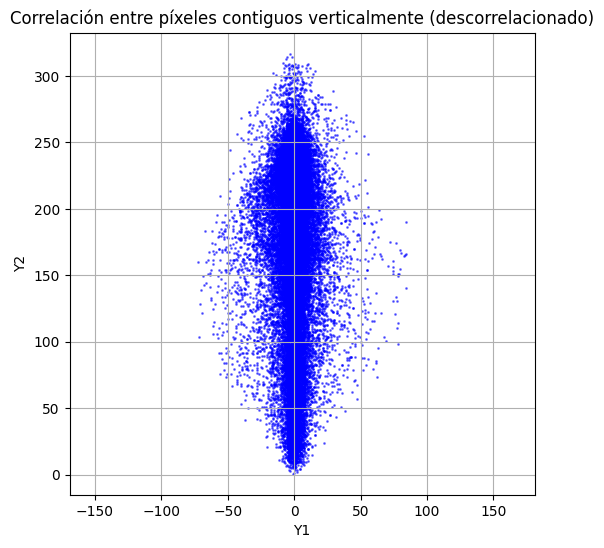

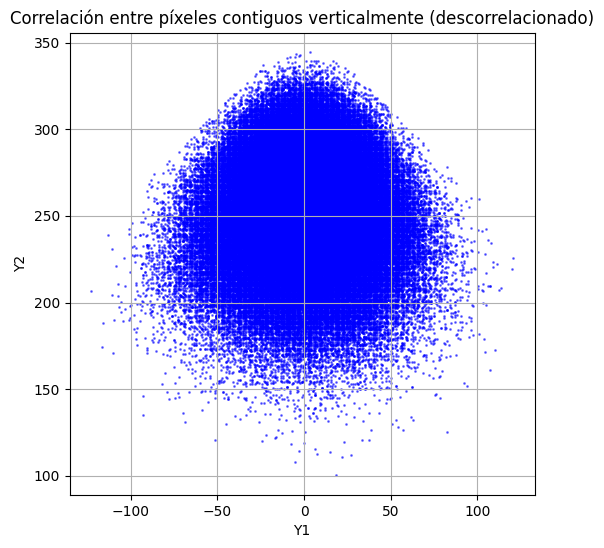

In [5]:

def img_to_vect(img):
    """
    Convierte una imagen en escala de grises a un vector de tipo float.
    """
    return img.astype(float).flatten()

def graficar_vector_imagen(img):
    """
    Grafica la imagen en escala de grises y un gráfico de dispersión
    que muestra la correlación entre píxeles contiguos verticalmente.
    """

    y1 = img[:-1, :].flatten().astype(float) # Píxeles en la fila i (ignorando la última fila)
    y2 = img[1:, :].flatten().astype(float) # Píxeles en la fila i+1 (ignorando la primera fila)

    _, axs = plt.subplots(1, 2, figsize=(12, 6)) # Crear subplots de bloques 2x1

    # Imagen en escala de grises (en la misma figura)
    axs[0].imshow(img, cmap="gray")
    axs[0].set_title("Imagen en escala de grises")
    axs[0].axis("off")

    # Gráfico de dispersión (en la misma figura)
    axs[1].scatter(y1, y2, color="red", alpha=0.5, s=1) # Puntos rojos con transparencia (0.5) y tamaño pequeño (1)
    axs[1].set_title("Correlación entre píxeles contiguos verticalmente")
    axs[1].set_xlabel("Y1 (píxel en fila i)")
    axs[1].set_ylabel("Y2 (píxel en fila i+1)")

    plt.tight_layout() # Ajustar el diseño para evitar solapamientos
    plt.show() # Mostrar la figura

def correlacion(img):
    y1 = img[:-1, :].flatten().astype(float) # Píxeles en la fila i (ignorando la última fila)
    y2 = img[1:, :].flatten().astype(float) # Píxeles en la fila i+1 (ignorando la primera fila)

    result = np.corrcoef(y1, y2)[0, 1] # Coeficiente de correlación entre y1 y y2
    return result


def descorrelacion(img):
    y1 = img[:-1, :].flatten().astype(float) # Píxeles en la fila i (ignorando la última fila)
    y2 = img[1:, :].flatten().astype(float) # Píxeles en la fila i+1 (ignorando la primera fila)

    X = np.vstack((y1, y2)).T # Matriz de datos (transpuesta para tener muestras en filas)

    cx = np.cov(X, rowvar=False) # Matriz de covarianza
    _, eigvecs = np.linalg.eigh(cx)  # Eigh para matrices simétricas

    # Proyectar X sobre la base de autovectores (descorrelacionar)
    Y = X @ eigvecs  # Equivalente a Y = P^T X si X es columna, usamos @ para matriz

    return Y

def graficar_vector(y, lista):
    """
    Grafica un gráfico de dispersión para los vectores Y1 y Y2.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(y[:, 0], y[:, 1], color="blue", alpha=0.5, s=1) # Puntos azules con transparencia (0.5) y tamaño pequeño (1)
    plt.title("Correlación entre píxeles contiguos verticalmente (descorrelacionado)")
    plt.xlabel(lista[0])
    plt.ylabel(lista[1])
    plt.axis('equal')  # Igualar las escalas de los ejes
    plt.grid(True)     # Añadir una cuadrícula para mejor visualización
    plt.show()        # Mostrar la figura

# Imagen 1
img1 = cv2.imread("img_01.jpg", cv2.IMREAD_GRAYSCALE)
graficar_vector_imagen(img1)

# Imagen 2
img2 = cv2.imread("img_02.jpg", cv2.IMREAD_GRAYSCALE)
graficar_vector_imagen(img2)

# Correlacion de imagen 1
coefs_img1 = correlacion(img1)
print("Coeficientes de correlación imagen 1:", coefs_img1)

# Correlacion del imagen 2
coefs_img2 = correlacion(img2)
print("Coeficientes de correlación imagen 2:", coefs_img2)

#Descorrelacion del vector X (PCA sin reducir dimension)
y1 = descorrelacion(img1)
y2 = descorrelacion(img2)

#Graficar vectores proyectados
graficar_vector(y1, ['Y1', 'Y2'])
graficar_vector(y2, ['Y1', 'Y2'])

# Ejercicio 2: Compresión 

(2537, 64) (64, 33)
Se ha guardado la informacion en data_img_03.npz


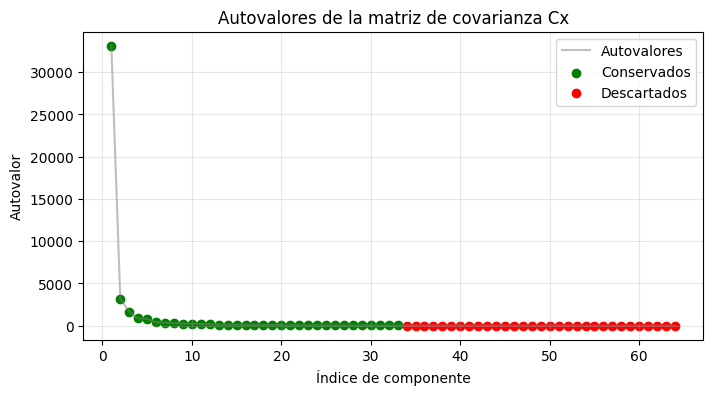

In [36]:
def space_saving_k(s:float, m:int):
    """
    Calcula el factor de compresión para un porcentaje de retención de información s y un número de componentes m.
    """
    if s>1 or s<0: raise ValueError("S debe representar un porcentaje valido")
    for k in range(1, m+1):
        if round(k/m) >= 1-s: return k
    return m  # no se encontro k, entonces no se comprime
        

def image_to_list_x(img:np.ndarray, size_b:int = 8):
    """
    Recorta de imagen obteniendo filas y columnas multiplos de **size_b**

    Realiza la division por bloques de tamaño **size_b . size_b**.

    LLeva los sub-bloques a un vector plano, en formato columna de (size_b * size_b, 1) """
    
    #Recorte de img 
    new_size_row = img.shape[0] - (img.shape[0]%size_b)
    new_size_col = img.shape[1] - (img.shape[1]%size_b)

    
    list_block_vectors = []
    for i in range(0, new_size_row, size_b):
        for j in range(0, new_size_col, size_b):
            block = img[i:i+size_b, j:j+size_b] #bloque de size_b * size_b
            block = block.astype(float).flatten(order='F')
            list_block_vectors.append(block) # 'F Fortran order (recorre por columnas) reshape lo lleva a un vec columna

    return list_block_vectors

def mean_estimator(matrix: np.ndarray)-> np.ndarray:
    return np.mean(matrix, axis=0) #hago el prom por las columnas para cada var

def cov_estimator(matrix: np.ndarray) -> np.ndarray:
    mu = mean_estimator(matrix)
    x_centered = matrix - mu.T  # broadcasting, np realiza la resta correspondiente a las dims
    return (x_centered.T @ x_centered) / (matrix.shape[0] - 1) #divido por 1/(n-1) donde n son la cantidad de muestras


def pca_trasnform(matrix_x:np.ndarray, cov:np.ndarray, mu:np.ndarray, k:int) -> np.ndarray:
    """
    Aplica PCA a los datos de entrada, retorna la matriz Y descorrelacionada de k componentes y la matriz de autovectores

    """
    evalues, evectors= np.linalg.eigh(cov) 
    idx_order = np.argsort(evalues)[::-1] #indices en base a los autovales
    evalues = evalues[idx_order] 
    evectors = evectors[:, idx_order]
    P = evectors[:, :k] #acorto los k componentes pricipales
    print(matrix_x.shape, P.shape)
    Y = (matrix_x - mu) @ P
    return Y, P

def save_data(matrix_y: np.ndarray, matrix_evectors: np.ndarray, mu:np.ndarray, filename: str)-> None:
    np.savez_compressed(filename, Y=matrix_y, P=matrix_evectors, mu=mu) #para cargar se usa np.load
    print("Se ha guardado la informacion en", filename)

def plot_eigenvalues(cov, k):
    evalues, _ = np.linalg.eigh(cov)
    evalues_sorted = np.sort(evalues)[::-1]
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(evalues_sorted)+1), evalues_sorted, label='Autovalores', ls = '-', color = 'grey', alpha=0.5)
    plt.scatter(range(1, k+1), evalues_sorted[:k], color='green', label='Conservados')
    if k < len(evalues_sorted):
        plt.scatter(range(k+1, len(evalues_sorted)+1), evalues_sorted[k:], color='red', label='Descartados')
    plt.xlabel('Índice de componente')
    plt.ylabel('Autovalor')
    plt.title('Autovalores de la matriz de covarianza Cx')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

img = cv2.imread("img_03.jpg", cv2.IMREAD_GRAYSCALE)
list_x = image_to_list_x(img) #lista de vect columna donde list_x[i] es la i-esima realizacion de x
matrix_x = np.vstack(list_x) #genero el vector donde las realizaciones son filas
mu = mean_estimator(list_x)
cov = cov_estimator(matrix_x) 
s_factor = space_saving_k(0.8, matrix_x.shape[1]) #siempre es de 64 en este caso m
matrix_y, matrix_evectors = pca_trasnform(matrix_x, cov, mu, k=s_factor)
save_data(matrix_y, matrix_evectors, mu, "data_img_03.npz")
plot_eigenvalues(cov, s_factor)



# Ejercicio 4: Medidas de desempeño